# SHREK - **S**entiment **H**arvesting for **R**eview **E**valuation via **K**nowledge

## Setup

Import the necessary libraries (we will use Keras because we are more familiar with it).

In [ ]:
!pip install --upgrade datasets fsspec huggingface_hub
!rm -rf ~/.cache/huggingface/datasets

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, LayerNormalization, MultiHeadAttention, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model as KerasModel
from datasets import load_dataset
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import os
import json # For saving Tokenizer config
from tokenizers import BertWordPieceTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import ssl
import urllib.request
import pickle
import zipfile
from tensorflow.keras.layers import Layer
from keras import ops
from collections import Counter

In [ ]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

### Global Configurations

Set Seeds for reproducibility.

In [ ]:
keras.utils.set_random_seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Set global variables.

In [ ]:
DATA_SAMPLE_TRAIN = 100000
DATA_SAMPLE_TEST = 10000
MAX_LEN = 100 # Max sequence length for padding
NUM_CLASSES = 5 # Yelp review stars (0-4)

Here we set the variables for the two tokenizers.

In [ ]:
WORD_VOCAB_SIZE = 20000
OOV_TOKEN = "<OOV>"

In [ ]:
BPE_VOCAB_SIZE = 15000 # Smaller vocab for bpe tokens

The GloVe configs (smallest possible GloVe used).

In [ ]:
GLOVE_FILE_NAME = "glove.6B.100d.txt"
GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_EMBEDDING_DIM = 100

Create the paths and the directories in which we will save our GloVe, Tokenizers and Models (because doing it every run would take too much computational power).

In [ ]:
EMBEDDINGS_DIR = './glove_embeddings'
TOKENIZERS_DIR = './saved_tokenizers'
MODELS_DIR = './saved_models'

In [ ]:
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
os.makedirs(TOKENIZERS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

Functions to save/load models.

In [ ]:
def save_keras_model(model, path):
    model.save(path)

def load_keras_model(path):
    if os.path.exists(path):
      model = load_model(path)
      return model
    else:
      print(f"No model found at {path}")
      return None

## Data Preprocess

Load Data

In [ ]:
def load_yelp_dataset(sample_train, sample_test):
    dataset = load_dataset("yelp_review_full")
    train_data = dataset['train']
    test_data = dataset['test']

    # in this way, we only keep the amount of data we wanted
    train_texts = train_data['text'][:sample_train]
    train_labels = train_data['label'][:sample_train]
    test_texts = test_data['text'][:sample_test]
    test_labels = test_data['label'][:sample_test]

    return train_texts, train_labels, test_texts, test_labels

In [ ]:
train_texts, train_labels, test_texts, test_labels = load_yelp_dataset(DATA_SAMPLE_TRAIN, DATA_SAMPLE_TEST)

# Convert labels to numpy arrays
train_labels_array = np.array(train_labels)
test_labels_array = np.array(test_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Plot piechart to see label distribution in train and test set.

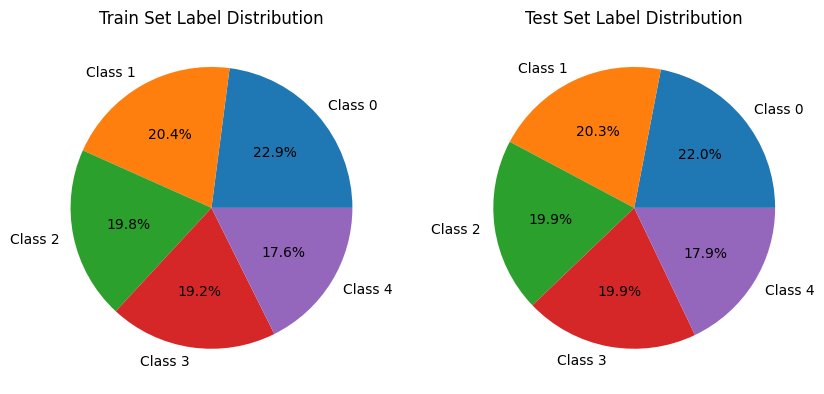

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.pie(
    [np.sum(train_labels_array == i) for i in range(NUM_CLASSES)],
    labels=[f"Class {i}" for i in range(NUM_CLASSES)],
    autopct='%1.1f%%')
plt.title('Train Set Label Distribution')
plt.subplot(1, 2, 2)
plt.pie(
    [np.sum(test_labels_array == i) for i in range(NUM_CLASSES)],
    labels=[f"Class {i}" for i in range(NUM_CLASSES)],
    autopct='%1.1f%%')
plt.title('Test Set Label Distribution')
plt.show()

### Preprocessing funtions.

Check if there are emojis.

In [ ]:
def _check_for_emojis(text):
  emoji_pattern = re.compile("[\U0001F600-\U0001F64F"
                           "\U0001F300-\U0001F5FF"
                           "\U0001F680-\U0001F6FF"
                           "\U0001F700-\U0001F77F"
                           "\U0001F780-\U0001F7FF"
                           "\U0001F800-\U0001F8FF"
                           "\U0001F900-\U0001F9FF"
                           "\U0001FA00-\U0001FA6F"
                           "\U0001FA70-\U0001FAFF"
                           "\U00002702-\U000027B0"
                           "\U000024C2-\U0001F251]+", flags=re.UNICODE)
  return bool(emoji_pattern.search(text))

In [ ]:
def _check_emojis_in_text(text):
  # turns the text into a series to then check if there are emojis,
  # if there are, it tells us.
  text = pd.Series(text)
  result = text.apply(_check_for_emojis)
  if True in result.values:
    print("There are emojis in the text.")
  else:
    print("There are no emojis in the text.")

In [ ]:
_check_emojis_in_text(train_texts)

There are no emojis in the text.


Lowercase to normalize all text.

In [ ]:
def _lowercase(text):
    return text.lower()

Revmove URLs because not carry sentiment.

In [ ]:
def _remove_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

Same goes for HTML.

In [ ]:
def _clean_html(text):
  html_pattern = re.compile('<.*?>')
  return html_pattern.sub(r'', text)

Remove punctuation, is in general useless to keep if our task is not to generate text, but as in our case, predict sentiment.

In [ ]:
def _remove_punctuation(text):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", text)

Stopwords appear a lot and do not carry sentiment, besides few that we keep.

In [ ]:
def _remove_stopwords(text):
    STOPWORDS = set(stopwords.words('english'))
    # List of stopwords to KEEP: important for sentiment
    KEEP_WORDS = {'not', 'no', 'nor', 'cannot', 'couldn', 'wouldn', 'shouldn',
                  'aren', 'wasn', 'weren', 'hasn', 'haven', 'hadn', 'don', 'doesn', 'didn'}
    CUSTOM_STOPWORDS = STOPWORDS.difference(KEEP_WORDS)
    words = text.split()
    filtered_words = [word for word in words if word not in CUSTOM_STOPWORDS and word.lower() != 'n']

    return " ".join(filtered_words)

Lemmatization (only for word level) because we do not need all the derivational forms of the words.

In [ ]:
def _lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

Pipeline for the word level preprocess.

In [ ]:
def preprocess_text_word_level(text):
    text = _lowercase(text)
    text = _remove_urls(text)
    text = _clean_html(text)
    text = _remove_punctuation(text)
    text = _remove_stopwords(text)
    text = _lemmatize_text(text)
    return text

### Create Tokenizers

We will use two tokenizers:


1.   Word Level just gets words out, perfect for the Embedding layer of keras and GloVe.
2.   Since we will use also a Transformer to predict the review score, for it we are going to use BPE tokenization with BertWordPiece.



Here we define the function to check if there is already a word level tokenizer, if not train it and save it.

In [ ]:
def get_word_level_tokenizer(texts, vocab_size, oov_token, tokenizer_path):
    tokenizer_file = os.path.join(tokenizer_path, "word_level_tokenizer.pkl") # Use pickle for saving the object

    # if there is a path, it loads the already present tokenizer
    if os.path.exists(tokenizer_file):
        print("Loading existing tokenizer...")
        with open(tokenizer_file, 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        print("Training new tokenizer...")
        # if there isn't, it trains it on our preprocessed corpus
        tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
        processed_texts = [preprocess_text_word_level(text) for text in texts]
        tokenizer.fit_on_texts(processed_texts)

        # and then saves it locally
        print("Saving tokenizer...")
        with open(tokenizer_file, 'wb') as f:
            pickle.dump(tokenizer, f)

    return tokenizer

Padding is essential to have all the sequences of text of the same length. The longer ones will be 'cut' by the MAX_LEN, while the shorter ones will have 0s to fill the missing space.

In [ ]:
def tokenize_and_pad_word_level(texts, tokenizer, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    # adds padding to compensate for sentences which are too short
    # or truncates those too long
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return padded_sequences

Byte-Pair-Encoding Tokeniker.

In [ ]:
def get_bpe_tokenizer(texts, vocab_size, tokenizer_path):
    tokenizer_file_prefix = os.path.join(tokenizer_path, "wordpiece_tokenizer")
    vocab_file = tokenizer_file_prefix + "-vocab.txt"
    model_file = tokenizer_file_prefix + ".json" # tokenizers library saves to .json

    if os.path.exists(model_file):
        tokenizer = BertWordPieceTokenizer.from_file(vocab_file=vocab_file, lowercase=True)
    else:
      # smaller, lighter preprocessing than word-level
        raw_texts_for_bpe = [_lowercase(_remove_urls(_clean_html(text))) for text in texts]
       # use bertwordpiece for BPE
        tokenizer = BertWordPieceTokenizer(
            clean_text=True,
            handle_chinese_chars=False,
            strip_accents=True)

        tokenizer.train_from_iterator(
            raw_texts_for_bpe,
            vocab_size=vocab_size,
            min_frequency=2,
            special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

        tokenizer.save_model(TOKENIZERS_DIR, "wordpiece_tokenizer") # Saves vocab.txt and .json

    return tokenizer

Tokenization and padding function for BPE.

In [ ]:
def encode_and_pad_bpe(texts, tokenizer, maxlen):
    processed_texts_for_bpe = [_lowercase(_remove_urls(_clean_html(text))) for text in texts]

    encoded_sequences = [
        tokenizer.encode(text).ids
        for text in processed_texts_for_bpe]
    padded_sequences = pad_sequences(encoded_sequences, maxlen=maxlen, padding='post', truncating='post')
    return padded_sequences

### Apply Preprocess and Tokenization

For Word level, apply preprocess and get our tokenized padded sequences.

In [ ]:
# word level preprocessed train and test sets
processed_train_texts_word_level = [preprocess_text_word_level(text) for text in train_texts]
processed_test_texts_word_level = [preprocess_text_word_level(text) for text in test_texts]

# bpe preprocessed train and test
word_tokenizer = get_word_level_tokenizer(processed_train_texts_word_level, WORD_VOCAB_SIZE, OOV_TOKEN, TOKENIZERS_DIR)
train_padded_word_level = tokenize_and_pad_word_level(processed_train_texts_word_level, word_tokenizer, MAX_LEN)
test_padded_word_level = tokenize_and_pad_word_level(processed_test_texts_word_level, word_tokenizer, MAX_LEN)

print(f"Word-level padded train shape: {train_padded_word_level.shape}")
print(f"Word-level padded test shape: {test_padded_word_level.shape}")

Loading existing tokenizer...
Word-level padded train shape: (100000, 100)
Word-level padded test shape: (10000, 100)


For BPE, apply all the steps prepared above.

In [ ]:
bpe_tokenizer = get_bpe_tokenizer(train_texts, BPE_VOCAB_SIZE, TOKENIZERS_DIR)  # Train on raw train_texts
                                                                                # because preprocess is done inside
train_padded_bpe = encode_and_pad_bpe(train_texts, bpe_tokenizer, MAX_LEN)
test_padded_bpe = encode_and_pad_bpe(test_texts, bpe_tokenizer, MAX_LEN)

print(f"BPE padded train shape: {train_padded_bpe.shape}")
print(f"BPE padded test shape: {test_padded_bpe.shape}")

bpe_actual_vocab_size = bpe_tokenizer.get_vocab_size()
print(f"BPE tokenizer actual vocabulary size: {bpe_actual_vocab_size}")

BPE padded train shape: (100000, 100)
BPE padded test shape: (10000, 100)
BPE tokenizer actual vocabulary size: 15000


## Preliminary Tests

Use a simple vectorization technique like TF-IDF with a simple model: LogisticRegression. Just a preliminary test to see how simple models can perform compared to more complex ones (both in terms of embedding and architecture).

In [ ]:
def get_tfidf_features(train_texts, test_texts):
    vectorizer = TfidfVectorizer(max_features=WORD_VOCAB_SIZE)
    vectorizer.fit(train_texts)

    train_features = vectorizer.transform(train_texts)
    test_features = vectorizer.transform(test_texts)
    return train_features, test_features

In [ ]:
def run_logistic_regression_test(train_features, train_labels, test_features, test_labels):
    lr_model = LogisticRegression(max_iter=500, random_state=42, n_jobs=-1)
    lr_model.fit(train_features, train_labels)

    predictions = lr_model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    report = classification_report(test_labels, predictions)

    print(f"Logistic Regression Test Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

In [ ]:
def generate_word_cloud(texts, title="Word Cloud"):
    tokens = " ".join(texts).split()
    token_freq = Counter(tokens)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        min_font_size=10,
        max_words=200,
        colormap='viridis').generate_from_frequencies(token_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)

    plt.show()

Perform the test.

In [ ]:
train_tfidf_features, test_tfidf_features = get_tfidf_features(
    processed_train_texts_word_level, processed_test_texts_word_level)
run_logistic_regression_test(
    train_tfidf_features, train_labels_array,
    test_tfidf_features, test_labels_array)

Logistic Regression Test Accuracy: 0.5613
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.77      0.72      2197
           1       0.49      0.46      0.47      2026
           2       0.48      0.45      0.46      1992
           3       0.49      0.48      0.48      1995
           4       0.64      0.64      0.64      1790

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



And generate a WordCloud, just fun and we can see also which are the most common words in our dataset.

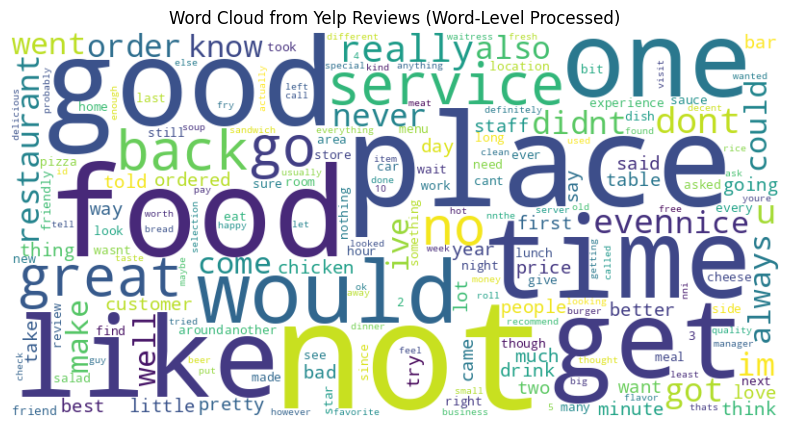

In [ ]:
generate_word_cloud(processed_train_texts_word_level,
                    title="Word Cloud from Yelp Reviews (Word-Level Processed)")

## Embedding

We want to see the possible impact of a pretrained embedding layer like GloVe. So we will use both a standard Embedding layer and then the same model, but using GloVe embeddings. (This could be done also with Word2Vec, but due to limited computational resources we will not).

GloVe Embedding download.

In [ ]:
def download_glove_embeddings(embeddings_dir, glove_url, glove_file_name):
    glove_zip_path = os.path.join(embeddings_dir, os.path.basename(glove_url))
    # Construct the expected path after extraction within the cache_subdir
    glove_extracted_dir = os.path.join(embeddings_dir, os.path.splitext(os.path.basename(glove_url))[0])
    glove_file_path = os.path.join(glove_extracted_dir, glove_file_name)

    if not os.path.exists(glove_file_path):
        print(f"Downloading GloVe embeddings from {glove_url} (this may take a while)...")

        # Create an unverified SSL context
        try:
            _create_unverified_https_context = ssl._create_unverified_context
        except AttributeError:
            # Legacy Python versions
            pass
        else:
            ssl._create_default_https_context = _create_unverified_https_context

        # Use the context in urlopen if needed (though get_file handles the urlopen call internally)
        # The primary fix is the unverified context setting above.

        tf.keras.utils.get_file(
            fname=os.path.basename(glove_url),
            origin=glove_url,
            extract=True,
            cache_dir='.',
            cache_subdir=embeddings_dir)
        print("GloVe embeddings downloaded and extracted.")
    else:
        print(f"GloVe embeddings ({glove_file_name}) already exist locally.")

    # Return the expected path to the extracted file
    return glove_file_path

Function to load our GloVe Embeddings.

In [ ]:
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

Function to create the emb matrix (weights that will be used in keras Embedding layer).

In [ ]:
def create_embedding_matrix(word_index, embeddings_index, vocab_size, embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    words_in_glove = 0
    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                words_in_glove += 1
    return embedding_matrix

Execute and get our GloVe Embedding.

In [ ]:
glove_file_path = download_glove_embeddings(EMBEDDINGS_DIR, GLOVE_URL, GLOVE_FILE_NAME)
glove_file_path = '/content/glove_embeddings/glove_extracted/glove.6B.100d.txt'
glove_embeddings_index = load_glove_embeddings(glove_file_path)
glove_embedding_matrix = create_embedding_matrix(
    word_tokenizer.word_index, glove_embeddings_index, WORD_VOCAB_SIZE, GLOVE_EMBEDDING_DIM)

GloVe embeddings downloaded and extracted.


## Models

### Creation

Embedding + LSTM

Model with two layers of LSTM Bidirectional, to capture better meaning from both the extremities of the sentence.

In [ ]:
def build_lstm_keras_embedding_model(vocab_size, embedding_dim, maxlen, num_classes):
  inputs = Input(shape=(maxlen,))
  embedding = Embedding(vocab_size, embedding_dim, input_length=maxlen)(inputs)
  lstm1 = Bidirectional(LSTM(32, use_cudnn=False, kernel_regularizer='l2'))(embedding)
  dropout = Dropout(0.5)(lstm1)
  outputs = Dense(num_classes, activation='softmax', kernel_regularizer='l2')(dropout)
  model = KerasModel(inputs=inputs, outputs=outputs)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
KERAS_EMBEDDING_DIM = 100
lstm_keras_embedding_model = build_lstm_keras_embedding_model(
    WORD_VOCAB_SIZE, KERAS_EMBEDDING_DIM, MAX_LEN, NUM_CLASSES)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 100, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,034,373 (7.76 MB)

 Trainable params: 2,034,373 (7.76 MB)

 Non-trainable params: 0 (0.00 B)

GloVe + LSTM

Here the same model as before, but we use GloVe embedding matrix.

In [ ]:
def build_lstm_glove_embedding_model(vocab_size, embedding_dim, maxlen, num_classes, embedding_matrix):
  inputs = Input(shape=(maxlen,))
  embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                  input_length=maxlen, trainable=False)(inputs) # Freeze emb learning to use GloVe weights
  lstm1 = Bidirectional(LSTM(32, use_cudnn=False, kernel_regularizer='l2'))(embedding)
  dropout = Dropout(0.5)(lstm1)
  outputs = Dense(num_classes, activation='softmax', kernel_regularizer='l2')(dropout)
  model = KerasModel(inputs=inputs, outputs=outputs)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
lstm_glove_embedding_model = build_lstm_glove_embedding_model(
    WORD_VOCAB_SIZE, GLOVE_EMBEDDING_DIM, MAX_LEN, NUM_CLASSES, glove_embedding_matrix)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 100, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,034,373 (7.76 MB)

 Trainable params: 34,373 (134.27 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Transformer

Very basic transformer with just one attention block.

In [ ]:
@keras.saving.register_keras_serializable()
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.5):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu", kernel_regularizer='l2'),
             Dense(embed_dim, kernel_regularizer='l2'),])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
@keras.saving.register_keras_serializable()
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
def build_transformer_model(vocab_size, maxlen, num_classes, embed_dim, num_heads, ff_dim, dropout_rate=0.5):
    inputs = Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block_1 = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block_1(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(ff_dim, activation="relu", kernel_regularizer='l2')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation="softmax", kernel_regularizer='l2')(x)

    model = KerasModel(inputs=inputs, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
TRANSFORMER_EMBED_DIM = 32
TRANSFORMER_NUM_HEADS = 4
TRANSFORMER_FF_DIM = 32

transformer_bpe_model = build_transformer_model(
    bpe_actual_vocab_size, MAX_LEN, NUM_CLASSES,
    TRANSFORMER_EMBED_DIM, TRANSFORMER_NUM_HEADS, TRANSFORMER_FF_DIM)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_2  │ (None, 100, 32)        │       483,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 100, 32)        │        19,040 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,461 (1.92 MB)

 Trainable params: 503,461 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

### Training and Evaluation

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12,6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

First model (LSTM + Emb).



In [ ]:
model1_path = os.path.join(MODELS_DIR, "lstm_keras_embedding_model.keras")
model1 = load_keras_model(model1_path)
if model1 is None:
    history1 = lstm_keras_embedding_model.fit(
        train_padded_word_level, train_labels_array,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1)
    save_keras_model(lstm_keras_embedding_model, model1_path)
    loss1, acc1 = lstm_keras_embedding_model.evaluate(test_padded_word_level, test_labels_array, verbose=0)
    print(f"Model 1 Test Loss: {loss1:.4f}, Test Accuracy: {acc1:.4f}")
    plot_history(history1)
else:
    loss1, acc1 = model1.evaluate(test_padded_word_level, test_labels_array, verbose=0)
    print(f"Loaded Model 1 Test Loss: {loss1:.4f}, Test Accuracy: {acc1:.4f}")

No model found at ./saved_models/lstm_keras_embedding_model.keras
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.3618 - loss: 1.9702 - val_accuracy: 0.5491 - val_loss: 1.1405
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5495 - loss: 1.1302 - val_accuracy: 0.5493 - val_loss: 1.1368
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.5840 - loss: 1.0607 - val_accuracy: 0.5505 - val_loss: 1.1685
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6049 - loss: 1.0242 - val_accuracy: 0.5556 - val_loss: 1.1609
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6240 - loss: 0.9929 - val_accuracy: 0.5525 - val_loss: 1.1776
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6355 - loss: 0.9716 - val_accuracy: 0.5572 - val_loss: 1.1594
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6502 - loss: 0.9486 - val_accuracy: 0.5522 - val_loss: 1.1805
Epoch 8/10
704/704 ━━━━━━

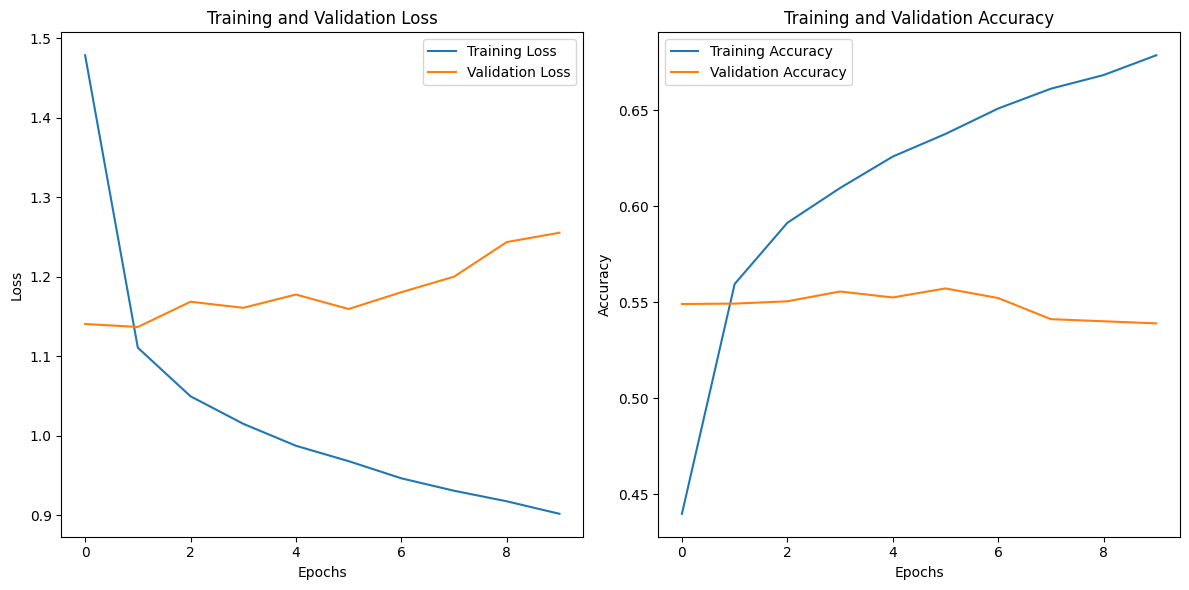

In [ ]:
plot_history(history1)

Second model (LSTM + GloVe).

No model found at ./saved_models/lstm_glove_embedding_model.keras
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3528 - loss: 2.0719 - val_accuracy: 0.4644 - val_loss: 1.3464
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.4571 - loss: 1.3448 - val_accuracy: 0.4642 - val_loss: 1.3218
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4658 - loss: 1.3136 - val_accuracy: 0.4437 - val_loss: 1.4067
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4692 - loss: 1.3094 - val_accuracy: 0.4611 - val_loss: 1.3463
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4795 - loss: 1.2846 - val_accuracy: 0.4758 - val_loss: 1.3192
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4843 - loss: 1.2684 - val_accuracy: 0.4868 - val_loss: 1.2948
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4908 - loss: 1.2578 - val_accuracy: 0.4814 - val_loss: 1.2871
Epoch 8/10
704/704 ━━━━━━━

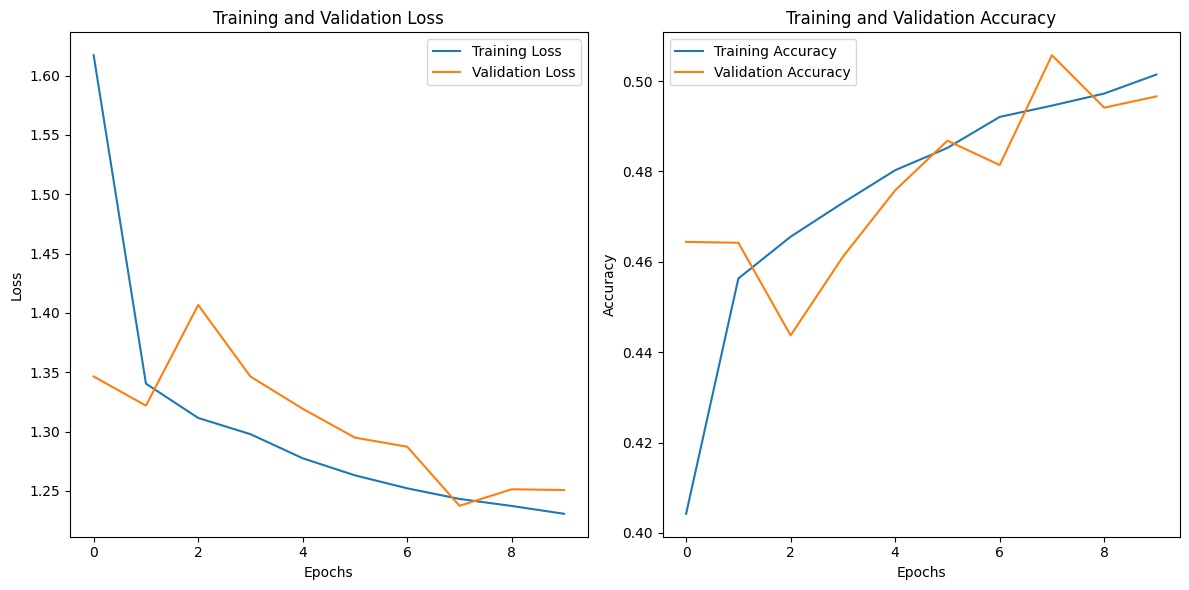

In [ ]:
model2_path = os.path.join(MODELS_DIR, "lstm_glove_embedding_model.keras")
model2 = load_keras_model(model2_path)
if model2 is None:
    history2 = lstm_glove_embedding_model.fit(
        train_padded_word_level, train_labels_array,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1)
    save_keras_model(lstm_glove_embedding_model, model2_path)
    loss2, acc2 = lstm_glove_embedding_model.evaluate(test_padded_word_level, test_labels_array, verbose=0)
    print(f"Model 2 Test Loss: {loss2:.4f}, Test Accuracy: {acc2:.4f}")
    plot_history(history2)
else:
    loss2, acc2 = model2.evaluate(test_padded_word_level, test_labels_array, verbose=0)
    print(f"Loaded Model 2 Test Loss: {loss2:.4f}, Test Accuracy: {acc2:.4f}")

Third model (Transformer w/ BPE enc).

No model found at ./saved_models/transformer_bpe_model.keras
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3323 - loss: 1.9825 - val_accuracy: 0.5306 - val_loss: 1.1526
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5279 - loss: 1.1850 - val_accuracy: 0.5433 - val_loss: 1.1237
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5584 - loss: 1.1214 - val_accuracy: 0.5391 - val_loss: 1.1504
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5763 - loss: 1.0838 - val_accuracy: 0.5317 - val_loss: 1.1943
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5890 - loss: 1.0529 - val_accuracy: 0.5260 - val_loss: 1.2401
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6042 - loss: 1.0234 - val_accuracy: 0.5206 - val_loss: 1.2987
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6085 - loss: 1.0104 - val_accuracy: 0.5256 - val_loss: 1.3266
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━

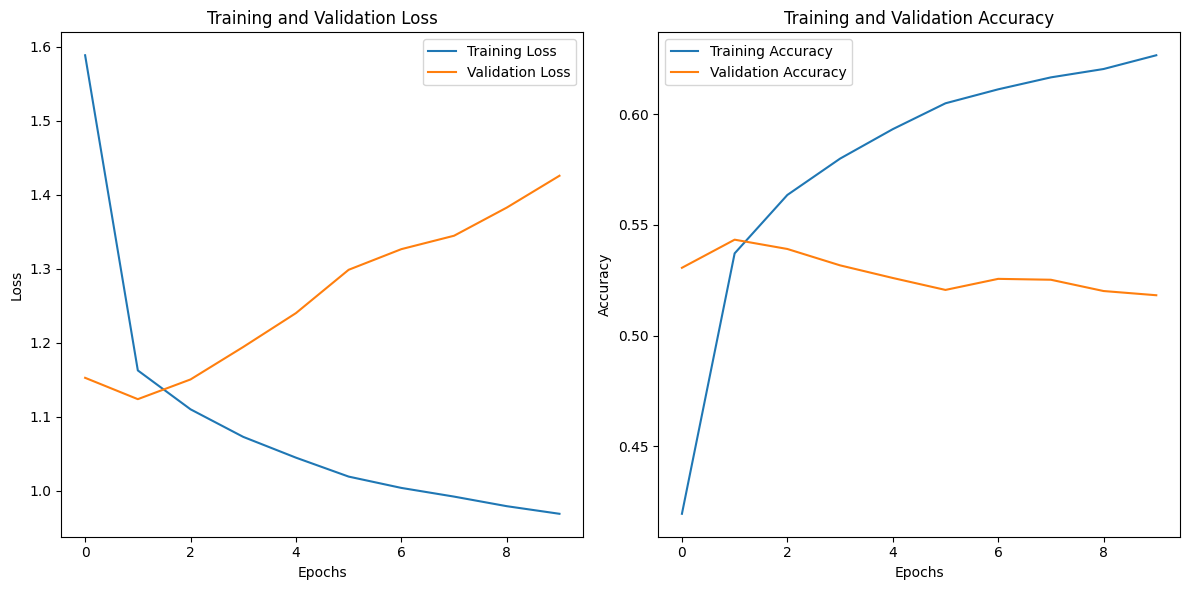

In [ ]:
model3_path = os.path.join(MODELS_DIR, "transformer_bpe_model.keras")
model3 = load_keras_model(model3_path)
if model3 is None:
    history3 = transformer_bpe_model.fit(
        train_padded_bpe, train_labels_array,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1)
    save_keras_model(transformer_bpe_model, model3_path)
    loss3, acc3 = transformer_bpe_model.evaluate(test_padded_bpe, test_labels_array, verbose=0)
    print(f"Model 3 Test Loss: {loss3:.4f}, Test Accuracy: {acc3:.4f}")
    plot_history(history3)
else:
    loss3, acc3 = model3.evaluate(test_padded_bpe, test_labels_array, verbose=0)
    print(f"Loaded Model 3 Test Loss: {loss3:.4f}, Test Accuracy: {acc3:.4f}")

Finally, let's define a way to see if our models are actually performing well by checking ourselves if the predictions are accurate, now using a set of fake reviews.

In [ ]:
fake_reviews = [
    "The pasta was fresh and flavorful, and the service was exceptional. Definitely coming back!",
    "Terrible experience. The food was cold, the waiter was rude, and we had to wait an hour.",
    "Average place. Portions were small but the taste was okay. Not bad, not great.",
    "Absolutely loved the ambiance! The risotto was creamy and perfectly cooked.",
    "Overpriced and overrated. The burger was dry, and the fries tasted like cardboard.",
    "It was okay. We had to wait an hour for our food, but it was worth it."
]

# prepare for model 1 and 2
fake_reviews_preprocessed = [preprocess_text_word_level(text) for text in fake_reviews]
fake_reviews_padded_word = tokenize_and_pad_word_level(fake_reviews_preprocessed, word_tokenizer, MAX_LEN)

# for model 3
fake_reviews_padded = encode_and_pad_bpe(fake_reviews, bpe_tokenizer, MAX_LEN)

pred_probs_model1 = lstm_keras_embedding_model.predict(fake_reviews_padded_word)
pred_probs_model2 = lstm_glove_embedding_model.predict(fake_reviews_padded_word)
pred_probs_model3 = transformer_bpe_model.predict(fake_reviews_padded)

pred_labels_model1 = np.argmax(pred_probs_model1, axis=1)
pred_labels_model2 = np.argmax(pred_probs_model2, axis=1)
pred_labels_model3 = np.argmax(pred_probs_model3, axis=1)

for i, review in enumerate(fake_reviews):
    print(f"Review: {review}\n")
    print(f"Model 1:     {pred_labels_model1[i]}")
    print(f"Model 2:     {pred_labels_model2[i]}")
    print(f"Model 3:     {pred_labels_model3[i]}\n")
    print("-" * 80)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
Review: The pasta was fresh and flavorful, and the service was exceptional. Definitely coming back!

Model 1:     4
Model 2:     4
Model 3:     4

--------------------------------------------------------------------------------
Review: Terrible experience. The food was cold, the waiter was rude, and we had to wait an hour.

Model 1:     0
Model 2:     0
Model 3:     0

--------------------------------------------------------------------------------
Review: Average place. Portions were small but the taste was okay. Not bad, not great.

Model 1:     1
Model 2:     1
Model 3:     1

--------------------------------------------------------------------------------
Review: Absolutely loved the ambiance! The risotto was creamy and perfectly cooked.

Model 1:     4
Model 2:     4
Model 3:     4

--------------------------------------------------------------------------------
Revie